In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [37]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [38]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

%matplotlib inline
warnings.simplefilter('ignore')

# plt.rcParams.update({'font.size': 13,
#                      'xtick.labelsize' : 13,
#                      'ytick.labelsize' : 13})

#### LOAD GLOPAP 
####  take relevant parts of dataframe and make arrays
#### CONVERT DIC AND TA FROM UMOL/KG TO MMOL/M3

In [39]:
import pandas as pd

#df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2019_Merged_Master_File.csv')
df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2020_Merged_Master_File.csv')

# data_top = list(df.columns) 
# print(data_top)

In [40]:
#need - bottom depth, pressure, dic, ta, salinity, temp, lat, lon
tALK = np.array(df['talk'][:])
tALK_orig = np.copy(tALK)
tDIC = np.array(df['tco2'][:])
tDIC_orig = np.copy(tDIC)
tSAL = np.array(df['salinity'][:])
tTEMP = np.array(df['temperature'][:])
tPRES = np.array(df['pressure'][:])
tLAT = np.array(df['latitude'][:])
tLON = np.array(df['longitude'][:])
tBOTdepth = np.array(df['bottomdepth'][:])
tYEAR = np.array(df['year'])
tOXY = np.array(df['oxygen'])
#tAOU = np.array(df['aou'][:])

#convert from umol/kg to mmol/m3
import seawater
dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC=tDIC*dens/1000
tALK=tALK*dens/1000

tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)

tpcfc11 = np.array(df['pcfc11'][:])
tpcfc12 = np.array(df['pcfc12'][:])
tpsf6 = np.array(df['psf6'][:])

In [41]:
### egleston calculations
def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A

# t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
# calculate_Egleston_factors\
# (tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)



def calculate_Egleston_factors_tPOT(ttemp, tsal, talk, tdic_A, dep, del_dic):

    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A



##### filters - TA and DIC, TEMP, SAL should exist, depth < 500, TA-DIC conditions, etc, filt_comp is a comprehensive filter of everything


In [42]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
#filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 2000)
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_AOU



filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

filt_cfc = (((tpcfc11>-999) & (~np.isnan(tpcfc11))) | \
               ((tpcfc12>-999) & (~np.isnan(tpcfc12))) | \
               ((tpsf6>-999) & (~np.isnan(tpsf6))) )

filt_comp_cfc = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR & filt_cfc & filt_OXY


# print('total_datapoints with DIC measurements')
# print(np.shape(filt_DIC))
# print('total datapoints with our filt-comp')
# print(np.shape(np.where(filt_comp)))
# print('total datapoints with our filt-comp-cfc')
# print(np.shape(np.where(filt_comp_cfc)))
# print('total datapoints with our filt-comp with abs(TA-DIC)<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC)))
# print('total datapoints with our filt-comp with abs(TA-(DIC+50))<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC2)))

In [43]:
###### manually assign geolocations
tGEO = np.zeros_like(tBOTdepth)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1

#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

In [44]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan \n Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

print(list_places)


['Everything Else', 'Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean']


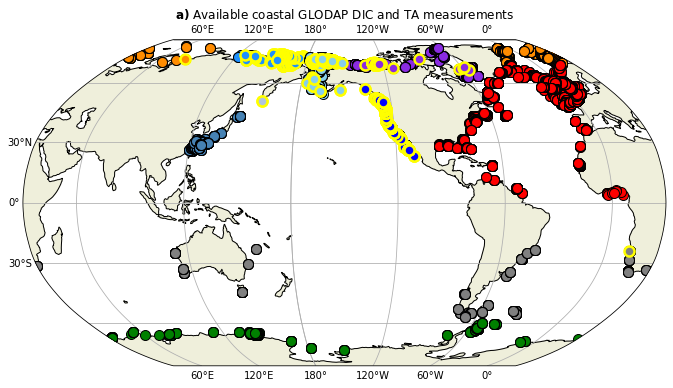

In [45]:
import cartopy.crs as ccrs
from cartopy import crs, feature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 20
# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.coastlines(facecolor = 'k')
# ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='darkgray'))
ax.add_feature(feature.LAND)


for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    #print(tLON[filt_comp & (tGEO == geotag)])
    ax.plot(tLON[filt_comp & (tGEO == geotag)],\
            tLAT[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
    ax.plot(tLON[filt_comp & filt_ALK_DIC & (tGEO == geotag)],\
            tLAT[filt_comp &  filt_ALK_DIC & (tGEO == geotag)],\
           color = tcol, marker = '.', markersize = ms, linestyle = '',\
            markeredgecolor = 'yellow', markeredgewidth = 2.5,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
# gl = ax.gridlines(draw_labels=False, xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 15))
# gl.rotate_labels = False
# gl.top_labels = False
# gl.bottom_labels = False

gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
# gl.top_labels = False
gl.left_labels = gl.bottom_labels = True
#gl.right_labels = gl.top_labels = False

# gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
# gl.xlabels_top = False
# gl.ylabels_left = False
# gl.ylabels_right=True
# gl.xlines = True
# gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
# gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'color': 'black', 'weight': 'normal'}

plt.title(r'$\bf{a)}$ Available coastal GLODAP DIC and TA measurements')
plt.show()
fig.savefig('./CG_FIGS/FIG_CG_08_map.jpg')



# PLOT AVAILABLE COASTAL OBSERVATIONS IN DIC/TA SPACE...

It's unsurprisingly a bit of a mess. But even plotting means with DIC and TA std. devs. could be relevant? tells more of a story.

Text(0.5, 0.98, 'Coastal observations in DIC/TA space')

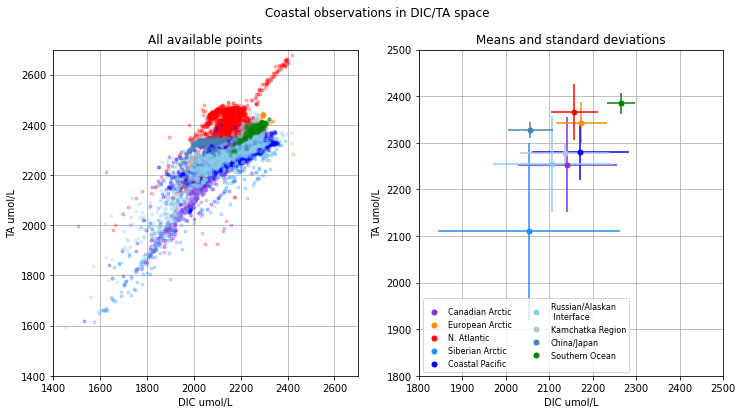

In [46]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,10*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
ax.grid()
ax.set_xlim([1400,2700])
ax.set_ylim([1400,2700])

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tALK[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tDIC[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tALK[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

plt.suptitle('Coastal observations in DIC/TA space')


In [47]:
print((PLACES_withdat[list_places[7]]))
print(geotag)
tdic = tDIC[filt_comp & (tGEO == 7)]
talk = tALK[filt_comp & (tGEO == 7)]

print((talk-tdic))

print(np.nanstd(talk+tdic))

{'geodat': 7, 'colour': 'lightsteelblue', 'name': 'Kamchatka Region'}
9
[254.84745128 242.68751677 193.20586007 159.42125497 133.32078498
  65.61888235  40.97802827  44.67809834]
124.31708401771604


Text(0.5, 0.98, 'Coastal observations in temp/sal space')

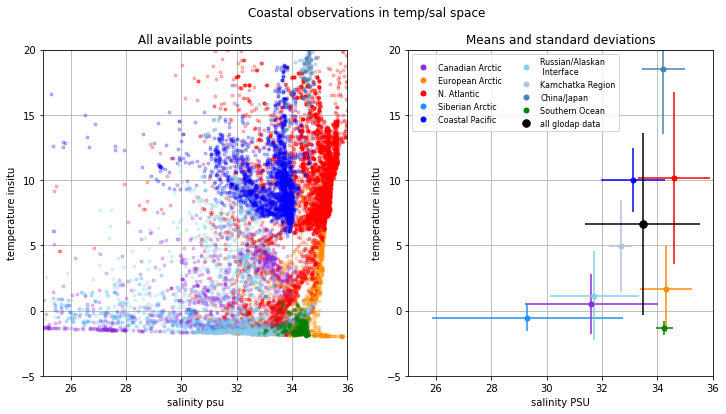

In [48]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,10*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tSAL[filt_comp & (tGEO == geotag)],\
            tTEMP[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
ax.grid()
ax.set_xlim([25,36])
ax.set_ylim([-5,20])

ax.set_ylabel('temperature insitu')
ax.set_xlabel('salinity psu')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tSAL[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tTEMP[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tSAL[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tTEMP[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tSAL[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tTEMP[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
    
    
ax.plot(np.nanmean(tSAL[filt_comp]),\
        np.nanmean(tTEMP[filt_comp]),\
       color = 'k', marker = '.', markersize = ms+5, \
        linestyle = '',\
       label = 'all glodap data', alpha = 1)
ax.errorbar(np.nanmean(tSAL[filt_comp]),\
            np.nanmean(tTEMP[filt_comp]), \
            xerr = np.nanstd(tSAL[filt_comp]),\
            yerr = np.nanstd(tTEMP[filt_comp]),
            fmt="o",
           color = 'k', marker = '.', linestyle = '',\
        alpha = 1)
ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('temperature insitu')
ax.set_xlabel('salinity PSU')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([25,36])
ax.set_ylim([-5,20])

plt.suptitle('Coastal observations in temp/sal space')


### calculate factors! 

In [49]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = 30
T[:] = 10

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i


DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

#def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
omega_DIC_r= omega_DIC.reshape(130,130)
OmegaA_A_r = OmegaA_A.reshape(130,130)

In [50]:
# ptmp(s, t, p, pr=0)
# help(seawater.eos80)

## do this for other S and T values

In [51]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = 32
T[:] = 10

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i

DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S32_T10= omega_DIC.reshape(130,130)
OmegaA_A_r_S32_T10 = OmegaA_A.reshape(130,130)
####
S[:] = 32
T[:] = 20


response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S32_T20= omega_DIC.reshape(130,130)
OmegaA_A_r_S32_T20 = OmegaA_A.reshape(130,130)

S[:] = 20
T[:] = 10
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S20_T10= omega_DIC.reshape(130,130)
OmegaA_A_r_S20_T10 = OmegaA_A.reshape(130,130)

S[:] = 20
T[:] = 20
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S20_T20= omega_DIC.reshape(130,130)
OmegaA_A_r_S20_T20 = OmegaA_A.reshape(130,130)

S[:] = 33
T[:] = 7
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S33_T7= omega_DIC.reshape(130,130)
OmegaA_A_r_S33_T7 = OmegaA_A.reshape(130,130)


# Put it together

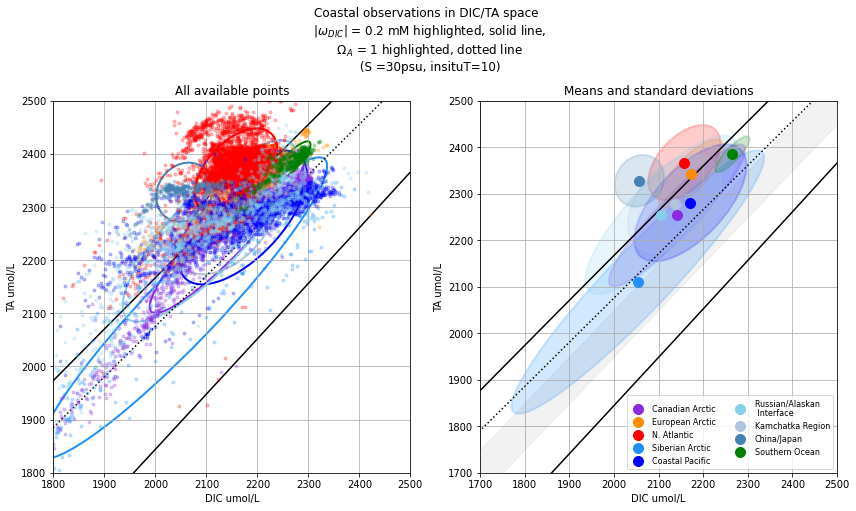

In [52]:
talph = 0.25
fact = 0.6
omega_lev = 0.2
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(20*fact,12*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc='None', lw=2)
    ax.add_patch(ellipse)

    ax.plot(x,y,\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 20

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc=tcol, alpha = 0.2, lw=2)
    ax.add_patch(ellipse)

#     ax.plot(x,y,\
#            color = tcol, marker = '.', linestyle = '',\
#            label = tnam, alpha = talph)
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
#     ax.errorbar(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
#                 np.nanmean(tALK[filt_comp & (tGEO == geotag)]), \
#                 xerr = np.nanstd(tDIC[filt_comp & (tGEO == geotag)]),\
#                 yerr = np.nanstd(tALK[filt_comp & (tGEO == geotag)]),
#                 fmt="o",
#                color = tcol, marker = '.', linestyle = '',\
#             alpha = 1)
ax.legend(ncol = 2, loc = 'lower right', fontsize = 8)
ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1700,2500])
ax.set_ylim([1700,2500])
ax.contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k' )
plt.suptitle('Coastal observations in DIC/TA space \n |$\omega_{DIC}$| = 0.2 mM highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line \n (S =30psu, insituT=10)')

DIC_guide = np.arange(1700,2700,1)
DIC_guide_pls50 = DIC_guide+50
DIC_guide_min50 = DIC_guide-50

# ax.plot(DIC_guide,DIC_guide_pls50,'r-')
# ax.plot(DIC_guide,DIC_guide_min50, 'r-')
ax.fill_between(DIC_guide, DIC_guide_pls50, DIC_guide_min50, color = 'grey', alpha = 0.1, zorder = 3)
plt.tight_layout()




In [53]:
ttemp = 10
tsal = 30
talk = 2500 * 1e-3
tdic_B = 2450 * 1e-3
tzero = 0
dep = 0
response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup
    
print(OmegaA_B)

[1.01038292]


In [54]:
#
BR3_DIC = pickle.load(open('./pkls/BR3_DIC_fullyear_mean.pkl', 'rb'))
BR3_TA = pickle.load(open('./pkls/BR3_TA_fullyear_mean.pkl', 'rb'))
PI9_DIC = pickle.load(open('./pkls/PI9_DIC_fullyear_mean.pkl', 'rb'))
PI9_TA = pickle.load(open('./pkls/PI9_TA_fullyear_mean.pkl', 'rb'))
csd = pickle.load(open('../pkls/cellsize_alg2.pkl','rb'))

# csd[np.where(BR3_DIC > 1e10)] = 0
# csd[np.where(BR3_DIC == np.nan)] = 0
# print(np.nanmean(BR3_DIC))
# print(np.nanmean(BR3_DIC))

# average = np.average(BR3_DIC, weights=csd)
# print(average)
take_csd = csd[csd>0]
take_BR3_DIC = BR3_DIC[csd>0]
take_BR3_TA = BR3_TA[csd>0]
take_PI9_DIC = PI9_DIC[csd>0]
take_PI9_TA = PI9_TA[csd>0]
# print(np.max(take_BR3_DIC))
# print(np.min(take_BR3_DIC))

print('TA')
average_TA_BR3 = np.average(take_BR3_TA, weights=take_csd)
print(average_TA_BR3)
average_TA_PI9 = np.average(take_PI9_TA, weights=take_csd)
print(average_TA_PI9)

print('DIC (BR/PI)')
average_DIC_BR3 = np.average(take_BR3_DIC, weights=take_csd)
print(average_DIC_BR3)
average_DIC_PI9 = np.average(take_PI9_DIC, weights=take_csd)
print(average_DIC_PI9)

print('TAminDIC (BR/PI)')

BR3_std_TAminDIC = np.sqrt(np.cov((take_BR3_TA-take_BR3_DIC), aweights=take_csd))
print(BR3_std_TAminDIC)
PI9_std_TAminDIC = np.sqrt(np.cov((take_PI9_TA-take_PI9_DIC), aweights=take_csd))
print(PI9_std_TAminDIC)

print('TAplsDIC (BR/PI)')
BR3_std_TAplsDIC = np.sqrt(np.cov((take_BR3_TA+take_BR3_DIC), aweights=take_csd))
print(BR3_std_TAplsDIC)
PI9_std_TAplsDIC = np.sqrt(np.cov((take_PI9_TA+take_PI9_DIC), aweights=take_csd))
print(PI9_std_TAplsDIC)


# average_TA_BR3
# average_DIC_BR3
# BR3_std_TAminDIC
# BR3_std_TAplsDIC
# average_TA_PI9
# average_DIC_PI9
# PI9_std_TAminDIC
# PI9_std_TAplsDIC

TA
2147.3380047551364
2150.8990132582526
DIC (BR/PI)
2082.4193076366128
2048.0739471352395
TAminDIC (BR/PI)
36.36653382896031
35.70699183440908
TAplsDIC (BR/PI)
170.47577244109488
169.88546358635722


### make 2d hists because ugghghhggh

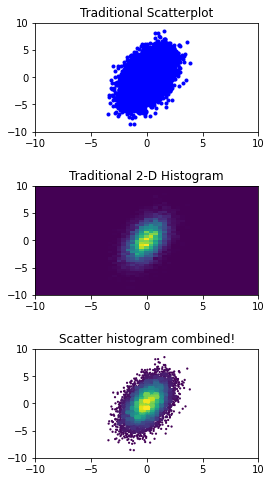

In [55]:
def map_hist(x, y, h, bins):
    xi = np.digitize(x, bins[0]) - 1
    yi = np.digitize(y, bins[1]) - 1
    inds = np.ravel_multi_index((xi, yi),
                                (len(bins[0]) - 1, len(bins[1]) - 1),
                                mode='clip')
    vals = h.flatten()[inds]
    bads = ((x < bins[0][0]) | (x > bins[0][-1]) |
            (y < bins[1][0]) | (y > bins[1][-1]))
    vals[bads] = np.NaN
    return vals


def scatter_hist2d(x, y,
                   s=20, marker=u'o',
                   mode='mountain',
                   bins=10, range=None,
                   normed=False, weights=None,  # np.histogram2d args
                   edgecolors='none',
                   ax=None, dens_func=None,
                   **kwargs):
    """
    Make a scattered-histogram plot.
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ), optional, default: 20
        size in points^2.
    marker : `~matplotlib.markers.MarkerStyle`, optional, default: 'o'
        See `~matplotlib.markers` for more information on the different
        styles of markers scatter supports. `marker` can be either
        an instance of the class or the text shorthand for a particular
        marker.
    mode: [None | 'mountain' (default) | 'valley']
       Possible values are:
       - None : The points are plotted as one scatter object, in the
         order in-which they are specified at input.
       - 'mountain' : The points are sorted/plotted in the order of
         the number of points in their 'bin'. This means that points
         in the highest density will be plotted on-top of others. This
         cleans-up the edges a bit, the points near the edges will
         overlap.
       - 'valley' : The reverse order of 'mountain'. The low density
         bins are plotted on top of the high-density ones.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:
          * If int, the number of bins for the two dimensions (nx=ny=bins).
          * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
          * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
          * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
          * A combination [int, array] or [array, int], where int
            is the number of bins and array is the bin edges.
    range : array_like, shape(2,2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the `bins` parameters):
        ``[[xmin, xmax], [ymin, ymax]]``. All values outside of this range
        will be considered outliers and not tallied in the histogram.
    normed : bool, optional
        If False, returns the number of samples in each bin. If True,
        returns the bin density ``bin_count / sample_count / bin_area``.
    weights : array_like, shape(N,), optional
        An array of values ``w_i`` weighing each sample ``(x_i, y_i)``.
        Weights are normalized to 1 if `normed` is True. If `normed` is
        False, the values of the returned histogram are equal to the sum of
        the weights belonging to the samples falling into each bin.
    edgecolors : color or sequence of color, optional, default: 'none'
        If None, defaults to (patch.edgecolor).
        If 'face', the edge color will always be the same as
        the face color.  If it is 'none', the patch boundary will not
        be drawn.  For non-filled markers, the `edgecolors` kwarg
        is ignored; color is determined by `c`.
    ax : an axes instance to plot into.
    dens_func : function or callable (default: None)
        A function that modifies (inputs and returns) the dens
        values (e.g., np.log10). The default is to not modify the
        values, which will modify their coloring.
    kwargs : these are all passed on to scatter.
    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`
        The scatter instance.
    """
    if ax is None:
        ax = plt.gca()

    h, xe, ye = np.histogram2d(x, y, bins=bins,
                               range=range, normed=normed,
                               weights=weights)
    # bins = (xe, ye)
    dens = map_hist(x, y, h, bins=(xe, ye))
    if dens_func is not None:
        dens = dens_func(dens)
    iorder = slice(None)  # No ordering by default
    if mode == 'mountain':
        iorder = np.argsort(dens)
    elif mode == 'valley':
        iorder = np.argsort(dens)[::-1]
    x = x[iorder]
    y = y[iorder]
    dens = dens[iorder]
    return ax.scatter(x, y,
                      s=s, c=dens,
                      edgecolors=edgecolors,
                      marker=marker,
                      **kwargs)
    

if __name__ == '__main__':

    randgen = np.random.RandomState(84309242)
    npoint = 10000
    x = randgen.randn(npoint)
    y = 2 * randgen.randn(npoint) + x

    lims = [-10, 10]
    bins = np.linspace(lims[0], lims[1], 50)

    fig, axs = plt.subplots(3, 1, figsize=[4, 8],
                            gridspec_kw=dict(hspace=0.5))

    ax = axs[0]
    ax.plot(x, y, '.', color='b', )
    ax.set_title("Traditional Scatterplot")

    ax = axs[1]
    ax.hist2d(x, y, bins=[bins, bins])
    ax.set_title("Traditional 2-D Histogram")

    ax = axs[2]
    scatter_hist2d(x, y, bins=[bins, bins], ax=ax, s=5)
    ax.set_title("Scatter histogram combined!")

    for ax in axs:
        ax.set_xlim(lims)
        ax.set_ylim(lims)


In [56]:
#171
np.linspace(700, 2400, 86)

array([ 700.,  720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,
        880.,  900.,  920.,  940.,  960.,  980., 1000., 1020., 1040.,
       1060., 1080., 1100., 1120., 1140., 1160., 1180., 1200., 1220.,
       1240., 1260., 1280., 1300., 1320., 1340., 1360., 1380., 1400.,
       1420., 1440., 1460., 1480., 1500., 1520., 1540., 1560., 1580.,
       1600., 1620., 1640., 1660., 1680., 1700., 1720., 1740., 1760.,
       1780., 1800., 1820., 1840., 1860., 1880., 1900., 1920., 1940.,
       1960., 1980., 2000., 2020., 2040., 2060., 2080., 2100., 2120.,
       2140., 2160., 2180., 2200., 2220., 2240., 2260., 2280., 2300.,
       2320., 2340., 2360., 2380., 2400.])

In [57]:
np.min(take_PI9_TA)

738.0142634979666

Text(0.5, 0.98, 'Relative density histograms of DIC and TA in the PI and present-day case')

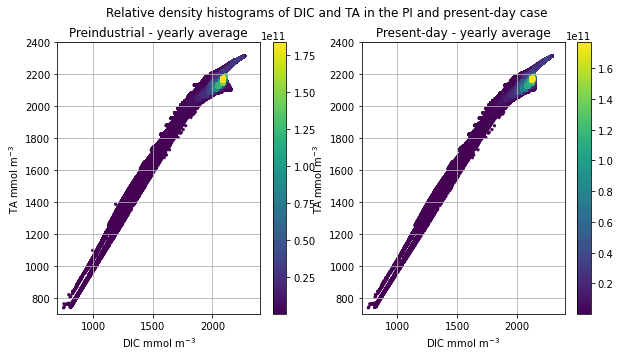

In [58]:
#https://stackoverflow.com/questions/40594520/off-centered-weighted-numpy-histogram2d

# plt.hist2d(take_BR3_DIC,take_BR3_TA,weights=take_csd, bins=[np.linspace(1700, 2400, 71),
#                             np.linspace(1700, 2400, 71)])

fig, axs = plt.subplots(1, 2, figsize=[10, 5],
                            gridspec_kw=dict(hspace=0.5))

# axs = axs.ravel()
# scatter_hist2d(take_BR3_DIC, take_BR3_TA, bins=[np.linspace(1700, 2400, 71),
#                             np.linspace(1700, 2400, 71)], ax=axs[0], s=5)
# plt.colorbar()



x = take_PI9_DIC; y = take_BR3_TA;
tbins = [np.linspace(700, 2400, 86), np.linspace(700, 2400, 86)]
tweights = take_csd
h, xe, ye = np.histogram2d(x, y, bins=tbins,
                           weights=tweights)
bins = (xe, ye)
dens = map_hist(x, y, h, bins=(xe, ye))
mode = 'mountain'
# if dens_func is not None:
#     dens = dens_func(dens)
iorder = slice(None)  # No ordering by default
if mode == 'mountain':
    iorder = np.argsort(dens)
elif mode == 'valley':
    iorder = np.argsort(dens)[::-1]
x = x[iorder]
y = y[iorder]
dens = dens[iorder]
w = axs[0].scatter(x, y,
                  s=5, c=dens,
                  edgecolors=None,
                  marker='o')

plt.colorbar(w, ax = axs[0])

x = take_BR3_DIC; y = take_BR3_TA;
tbins = [np.linspace(700, 2400, 86), np.linspace(700, 2400, 86)]
tweights = take_csd
h, xe, ye = np.histogram2d(x, y, bins=tbins,
                           weights=tweights)
bins = (xe, ye)
dens = map_hist(x, y, h, bins=(xe, ye))
mode = 'mountain'
# if dens_func is not None:
#     dens = dens_func(dens)
iorder = slice(None)  # No ordering by default
if mode == 'mountain':
    iorder = np.argsort(dens)
elif mode == 'valley':
    iorder = np.argsort(dens)[::-1]
x = x[iorder]
y = y[iorder]
dens = dens[iorder]
w = axs[1].scatter(x, y,
                  s=5, c=dens,
                  edgecolors=None,
                  marker='o')
plt.colorbar(w, ax = axs[1])

for i in range(0,2):
    
    axs[i].set_xlim([700,2400])
    axs[i].set_ylim([700,2400])
    axs[i].grid()
    axs[i].set_xlabel('DIC mmol m$^{-3}$')
    axs[i].set_ylabel('TA mmol m$^{-3}$')
    axs[0].set_title('Preindustrial - yearly average')
    axs[1].set_title('Present-day - yearly average')
    
plt.suptitle('Relative density histograms of DIC and TA in the PI and present-day case')

In [59]:
print(np.shape(dens))
print(np.nanmax(dens))
print(np.nanmin(dens))

print(np.nansum(dens))



(2103152,)
177002420519.86255
200783.0442696876
5.751678237499582e+16


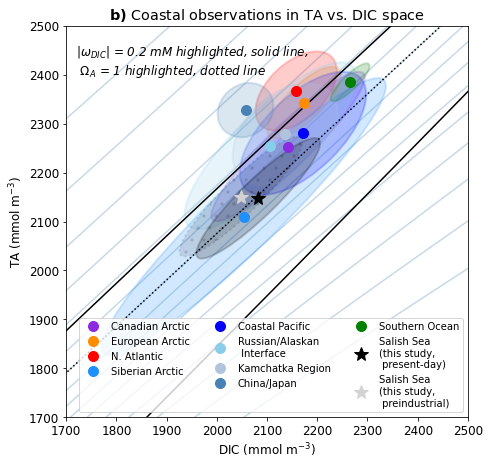

In [60]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 10}

fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))

ax = plt.subplot(1,1,1)
fs = 10
tcol = 'black'
tlw = 4.5
ms = 20

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc=tcol, alpha = 0.2, lw=2)
    ax.add_patch(ellipse)
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)


#####

average_TA_BR3
average_DIC_BR3
BR3_std_TAminDIC
BR3_std_TAplsDIC
average_TA_PI9
average_DIC_PI9
PI9_std_TAminDIC
PI9_std_TAplsDIC

x = average_DIC_BR3; y = average_TA_BR3

ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*BR3_std_TAplsDIC, height=2*BR3_std_TAminDIC, angle = 45,
                        edgecolor='k', fc='k', alpha = 0.2, lw=2)
ax.add_patch(ellipse)
ax.plot(x,y, marker = '*', markersize = ms-5, color = 'k', linestyle = '', label = 'Salish Sea\n(this study, \n present-day)')

x = average_DIC_PI9; y = average_TA_PI9

ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*PI9_std_TAplsDIC, height=2*PI9_std_TAminDIC, angle = 45,
                        edgecolor='k', fc='k', alpha = 0.1, hatch = '.', lw=2, linestyle = ':')
ax.add_patch(ellipse)

ax.plot(x,y, marker = '*', markersize = ms-5, color = 'lightgrey', linestyle = '', label = 'Salish Sea\n(this study, \n preindustrial)')



ax.set_ylabel('TA (mmol m$^{-3}$)')
ax.set_xlabel('DIC (mmol m$^{-3}$)')
#ax.set_title('Means and standard deviations')
# ax.grid()

# ax.plot([200,202], [200,202], linestyle = '-', color = 'k', label = 'walrus')
ax.set_xlim([1700,2500])
ax.set_ylim([1700,2500])


ax.contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
ax.legend(ncol = 3, loc = 'lower right', fontsize = 10)
ax.contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k', label = 'walrusbaby' )

w2 = ax.contour(X, Y, np.log(OmegaAr_vTD), levels=np.arange(-2.7,2,0.3), colors = 'steelblue', 
                   linestyles = '-', alpha = 0.3, zorder = 0)


ax.set_title(r'$\bf{b)}$ Coastal observations in TA vs. DIC space')
ax.text(1720,2400, '|$\omega_{DIC}$| = 0.2 mM highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line',\
        style = 'italic', fontsize = 12)
# \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line
fig.savefig('./CG_FIGS/FIG_CG_08_plot.jpg')



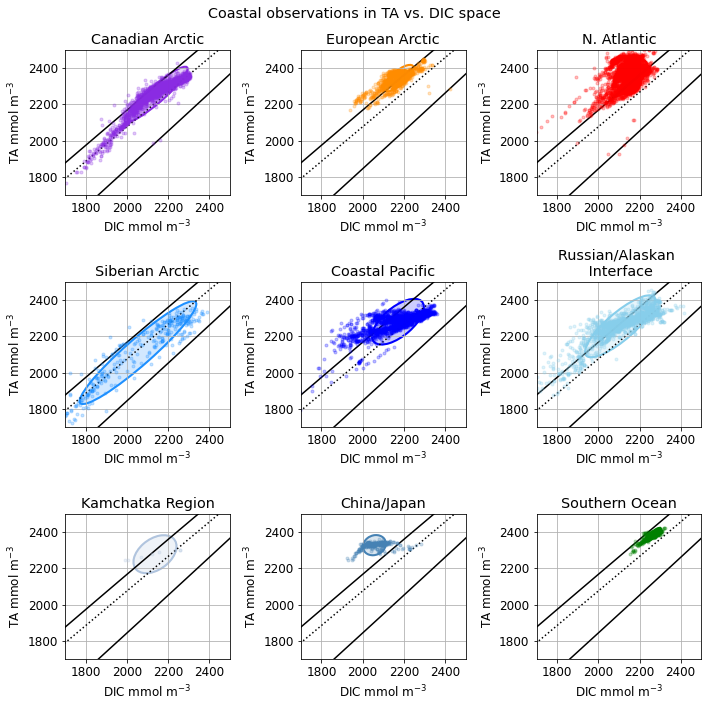

In [61]:
talph = 0.25
fact = 0.5
omega_lev = 0.2
from matplotlib.patches import Ellipse
fig, axs = plt.subplots(3,3, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc='None', lw=2)
    axs[i-1].add_patch(ellipse)

    axs[i-1].plot(x,y,\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
    
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc= tcol, lw=2, alpha = 0.2)
    axs[i-1].add_patch(ellipse)
    
    axs[i-1].set_xlim([1700,2500])
    axs[i-1].set_ylim([1700,2500])
    axs[i-1].grid()
    axs[i-1].set_title(f'{tnam}')

    axs[i-1].set_ylabel('TA mmol m$^{-3}$')
    axs[i-1].set_xlabel('DIC mmol m$^{-3}$')


    axs[i-1].contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
    #ax.legend(ncol = 3, loc = 'lower right', fontsize = 10)
    axs[i-1].contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k', label = 'walrusbaby' )


plt.suptitle('Coastal observations in TA vs. DIC space')
plt.tight_layout()


fig.savefig('./CG_FIGS/SFIG_CG_08_glodap-indiv.jpg', bbox_inches='tight', dpi = 300)



In [62]:
# https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy


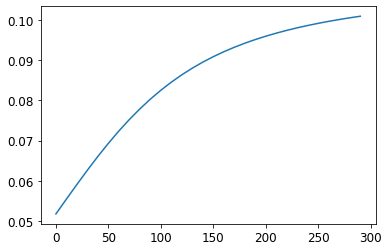

In [63]:


tamindic = np.arange(0,310,10.0)
omega = np.zeros_like(tamindic)

for i in range(0,len(tamindic)):

    ttemp = 10
    tsal = 30
    talk = 2500 * 1e-3
    tdic_B = (2500-(tamindic[i])) * 1e-3
    tzero = 0
    dep = 0
    
    calculate_Egleston_factors(ttemp, tsal, talk, tdic_B, 0, 10 * 1e-3)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                               sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega[i] = OmegaA_B[0]
    
    
# plt.plot(tamindic,omega)

omega_diff = np.zeros_like(omega)

for i in range(0,len(omega_diff)-1):
        omega_diff[i] = omega[i+1]-omega[i]
        
        
plt.plot(tamindic[0:30],omega_diff[0:30])

## temperature and salinity 

In [64]:
#
import gsw

PI9_temp_mu = pickle.load(open('./pkls/PI9_temp_fullyear_mean.pkl', 'rb'))
PI9_sal_mu = pickle.load(open('./pkls/PI9_sal_fullyear_mean.pkl', 'rb'))
csd = pickle.load(open('../pkls/cellsize_alg2.pkl','rb'))

PI9_sal = PI9_sal_mu*35/35.16504
PI9_temp = gsw.t_from_CT(PI9_sal_mu,PI9_temp_mu,np.zeros_like(PI9_temp_mu))

# csd[np.where(BR3_DIC > 1e10)] = 0
# csd[np.where(BR3_DIC == np.nan)] = 0
# print(np.nanmean(BR3_DIC))
# print(np.nanmean(BR3_DIC))

# average = np.average(BR3_DIC, weights=csd)
# print(average)
take_csd = csd[csd>0]
take_PI9_temp = PI9_temp[csd>0]
take_PI9_sal = PI9_sal[csd>0]
# print(np.max(take_BR3_DIC))
# print(np.min(take_BR3_DIC))

print('temp')
average_temp_PI9 = np.average(take_PI9_temp, weights=take_csd)
print(average_temp_PI9)
print('sal')
average_sal_PI9 = np.average(take_PI9_sal, weights=take_csd)
print(average_sal_PI9)

# print('TAminDIC (BR/PI)')

PI9_std_sal = np.sqrt(np.cov((take_PI9_sal), aweights=take_csd))
print(PI9_std_sal)
PI9_std_temp = np.sqrt(np.cov((take_PI9_temp), aweights=take_csd))
print(PI9_std_temp)

# print('TAplsDIC (BR/PI)')
# BR3_std_TAplsDIC = np.sqrt(np.cov((take_BR3_TA+take_BR3_DIC), aweights=take_csd))
# print(BR3_std_TAplsDIC)
# PI9_std_TAplsDIC = np.sqrt(np.cov((take_PI9_TA+take_PI9_DIC), aweights=take_csd))
# print(PI9_std_TAplsDIC)


# average_TA_BR3
# average_DIC_BR3
# BR3_std_TAminDIC
# BR3_std_TAplsDIC
# average_TA_PI9
# average_DIC_PI9
# PI9_std_TAminDIC
# PI9_std_TAplsDIC

temp
9.726992477047672
sal
30.409401894148793
1.575160918936356
0.7623788959314574


Text(0.5, 0.98, 'Coastal observations in temp/sal space')

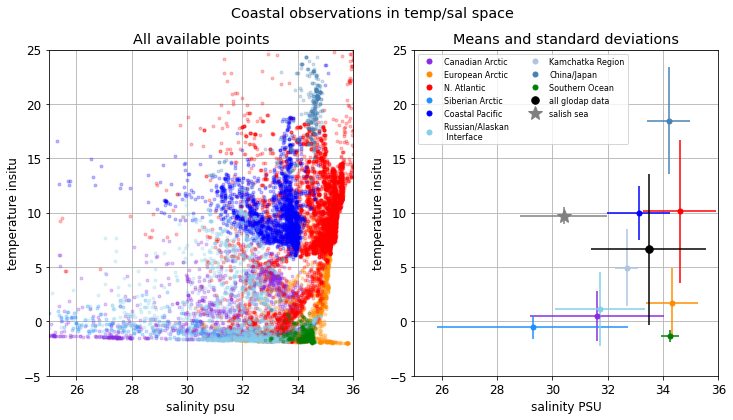

In [65]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,10*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tSAL[filt_comp & (tGEO == geotag)],\
            tTEMP[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
ax.grid()
ax.set_xlim([25,36])
ax.set_ylim([-5,25])

ax.set_ylabel('temperature insitu')
ax.set_xlabel('salinity psu')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tSAL[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tTEMP[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tSAL[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tTEMP[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tSAL[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tTEMP[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
    
    
ax.plot(np.nanmean(tSAL[filt_comp]),\
        np.nanmean(tTEMP[filt_comp]),\
       color = 'k', marker = '.', markersize = ms+5, \
        linestyle = '',\
       label = 'all glodap data', alpha = 1)
ax.errorbar(np.nanmean(tSAL[filt_comp]),\
            np.nanmean(tTEMP[filt_comp]), \
            xerr = np.nanstd(tSAL[filt_comp]),\
            yerr = np.nanstd(tTEMP[filt_comp]),
            fmt="o",
           color = 'k', marker = '.', linestyle = '',\
        alpha = 1)


ax.plot(average_sal_PI9,\
        average_temp_PI9,\
       color = 'grey', marker = '*', markersize = ms+5, \
        linestyle = '', label = 'salish sea', alpha = 1)
ax.errorbar(average_sal_PI9,\
            average_temp_PI9, \
            xerr = PI9_std_sal,\
            yerr = PI9_std_temp,
            fmt="o", color = 'grey', marker = '.', linestyle = '-',\
        alpha = 1)


ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('temperature insitu')
ax.set_xlabel('salinity PSU')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([25,36])
ax.set_ylim([-5,25])

plt.suptitle('Coastal observations in temp/sal space')


In [66]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = average_sal_PI9
T[:] = average_temp_PI9

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i


DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

#def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
omega_DIC_SSmean = omega_DIC.reshape(130,130)
OmegaA_A_SSmean = OmegaA_A.reshape(130,130)


##### for glodap

#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = np.nanmean(tSAL[filt_comp & (tGEO == geotag)])
T[:] = np.nanmean(tTEMP[filt_comp & (tGEO == geotag)])

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i


DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

#def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
omega_DIC_GLODAPmean = omega_DIC.reshape(130,130)
OmegaA_A_GLODAPmean = OmegaA_A.reshape(130,130)

Text(1720, 2400, '|$\\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\\Omega_{A}$ = 1 highlighted, dotted line \n red = SS mean, blue = glodap mean')

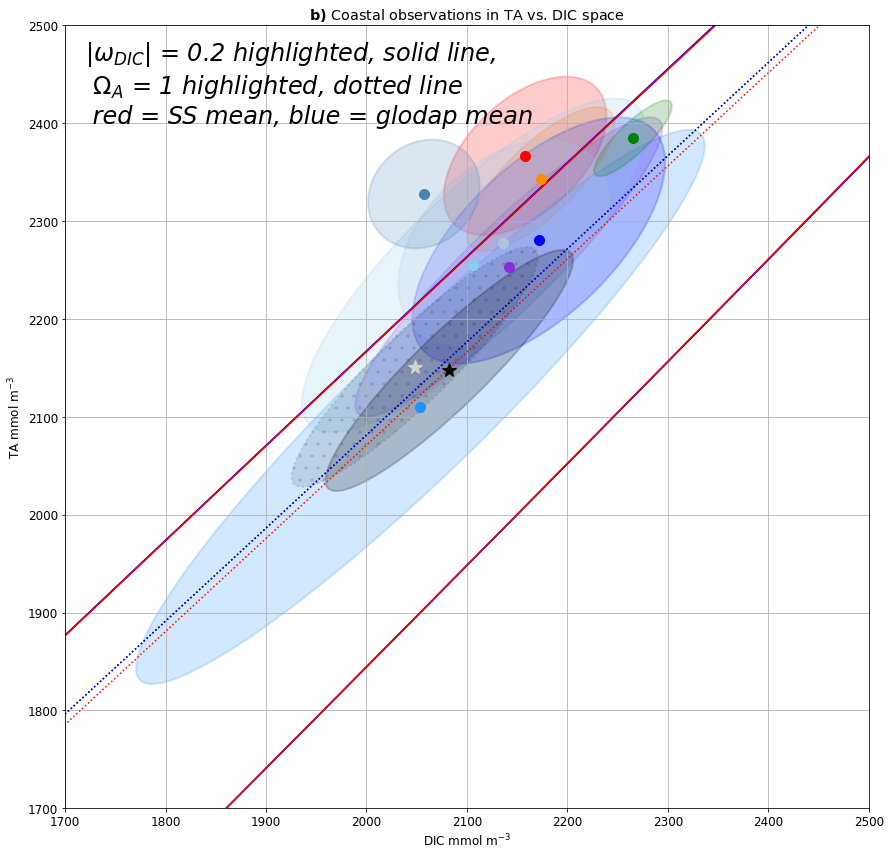

In [67]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 10}

fact = 1.2
fig = plt.figure(figsize=(12*fact,12*fact))

ax = plt.subplot(1,1,1)
fs = 10
tcol = 'black'
tlw = 4.5
ms = 20

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc=tcol, alpha = 0.2, lw=2)
    ax.add_patch(ellipse)
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)


#####

average_TA_BR3
average_DIC_BR3
BR3_std_TAminDIC
BR3_std_TAplsDIC
average_TA_PI9
average_DIC_PI9
PI9_std_TAminDIC
PI9_std_TAplsDIC
x = average_DIC_BR3; y = average_TA_BR3

ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*BR3_std_TAplsDIC, height=2*BR3_std_TAminDIC, angle = 45,
                        edgecolor='k', fc='k', alpha = 0.2, lw=2)
ax.add_patch(ellipse)
ax.plot(x,y, marker = '*', markersize = ms-5, color = 'k', linestyle = '', label = 'Salish Sea\n(this study, \n present-day)')

x = average_DIC_PI9; y = average_TA_PI9

ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*PI9_std_TAplsDIC, height=2*PI9_std_TAminDIC, angle = 45,
                        edgecolor='k', fc='k', alpha = 0.1, hatch = '.', lw=2, linestyle = ':')
ax.add_patch(ellipse)

ax.plot(x,y, marker = '*', markersize = ms-5, color = 'lightgrey', linestyle = '', label = 'Salish Sea\n(this study, \n preindustrial)')



ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC mmol m$^{-3}$')
#ax.set_title('Means and standard deviations')
ax.grid()

# ax.plot([200,202], [200,202], linestyle = '-', color = 'k', label = 'walrus')
ax.set_xlim([1700,2500])
ax.set_ylim([1700,2500])


ax.contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k', label = 'walrusbaby' )

ax.contour(X, Y, -omega_DIC_GLODAPmean, levels=[omega_lev], colors = 'b')
ax.contour(X, Y, OmegaA_A_GLODAPmean, levels=[1], linestyles = 'dotted', colors = 'b', label = 'walrusbaby' )

ax.contour(X, Y, -omega_DIC_SSmean, levels=[omega_lev], colors = 'r')
ax.contour(X, Y, OmegaA_A_SSmean, levels=[1], linestyles = 'dotted', colors = 'r', label = 'walrusbaby' )


ax.set_title(r'$\bf{b)}$ Coastal observations in TA vs. DIC space')
ax.text(1720,2400, '|$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line \n red = SS mean, blue = glodap mean',\
        style = 'italic', fontsize = 24)
# \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line


#fig.savefig('./CG_FIGS/FIG_CG_08_plot.jpg')



In [68]:

def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A

# t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
# calculate_Egleston_factors\
# (tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)

t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
calculate_Egleston_factors\
(tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)

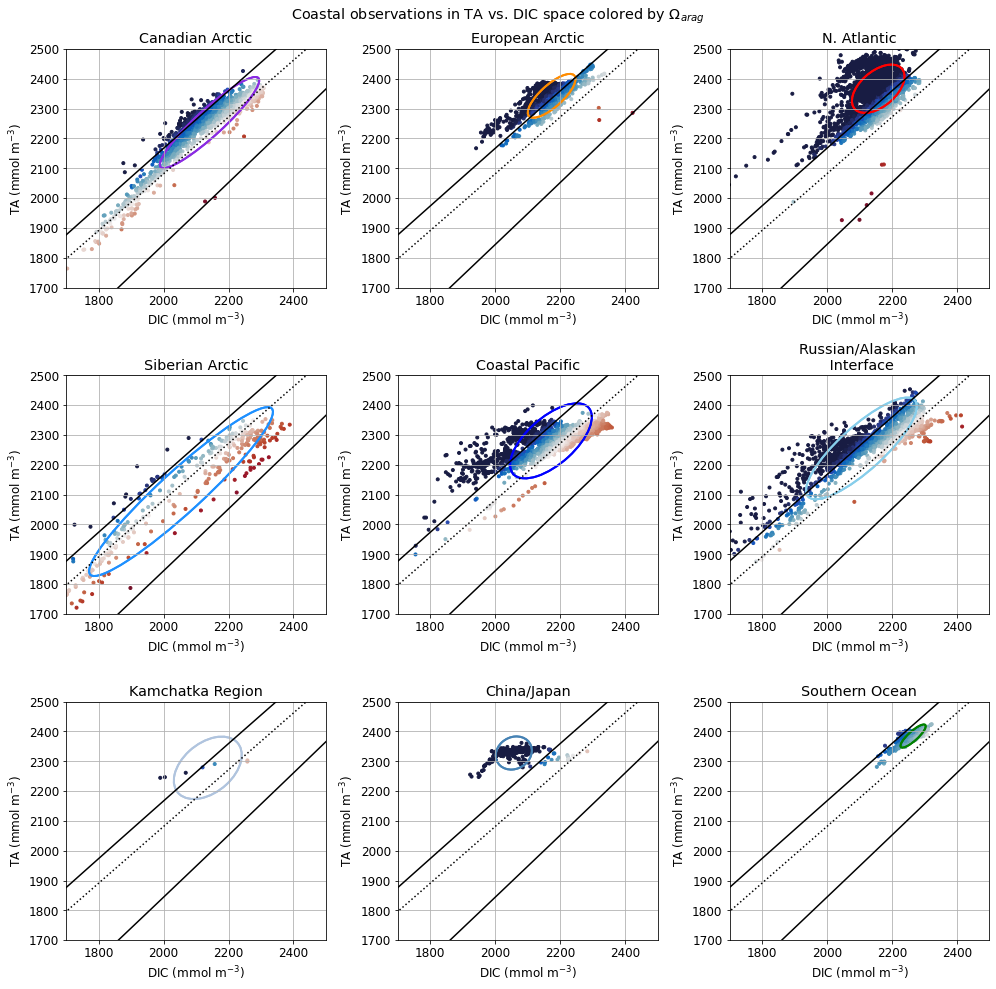

In [69]:
talph = 1
fact = 0.7
omega_lev = 0.2
from matplotlib.patches import Ellipse
fig, axs = plt.subplots(3,3, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc='None', lw=2)
    axs[i-1].add_patch(ellipse)
    
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    
    w = axs[i-1].scatter(x,y,\
           c = t_OmegaA_A[filt_comp & (tGEO == geotag)], marker = '.',\
           label = tnam, alpha = talph, vmin = 0, vmax = 2, cmap = cm.balance_r)
    
#     ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
#                             edgecolor=tcol, fc= tcol, lw=2, alpha = 0.2)
    axs[i-1].add_patch(ellipse)
    
    axs[i-1].set_xlim([1700,2500])
    axs[i-1].set_ylim([1700,2500])
    axs[i-1].grid()
    axs[i-1].set_title(f'{tnam}')

    axs[i-1].set_ylabel('TA (mmol m$^{-3}$)')
    axs[i-1].set_xlabel('DIC (mmol m$^{-3}$)')


    axs[i-1].contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
    #ax.legend(ncol = 3, loc = 'lower right', fontsize = 10)
    axs[i-1].contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k', label = 'walrusbaby' )

# fig.colorbar(w)
    
plt.suptitle('Coastal observations in TA vs. DIC space colored by $\Omega_{arag}$')
plt.tight_layout()


fig.savefig('./CG_FIGS/SFIG_17_glodap-indiv.jpg', bbox_inches='tight', dpi = 300)



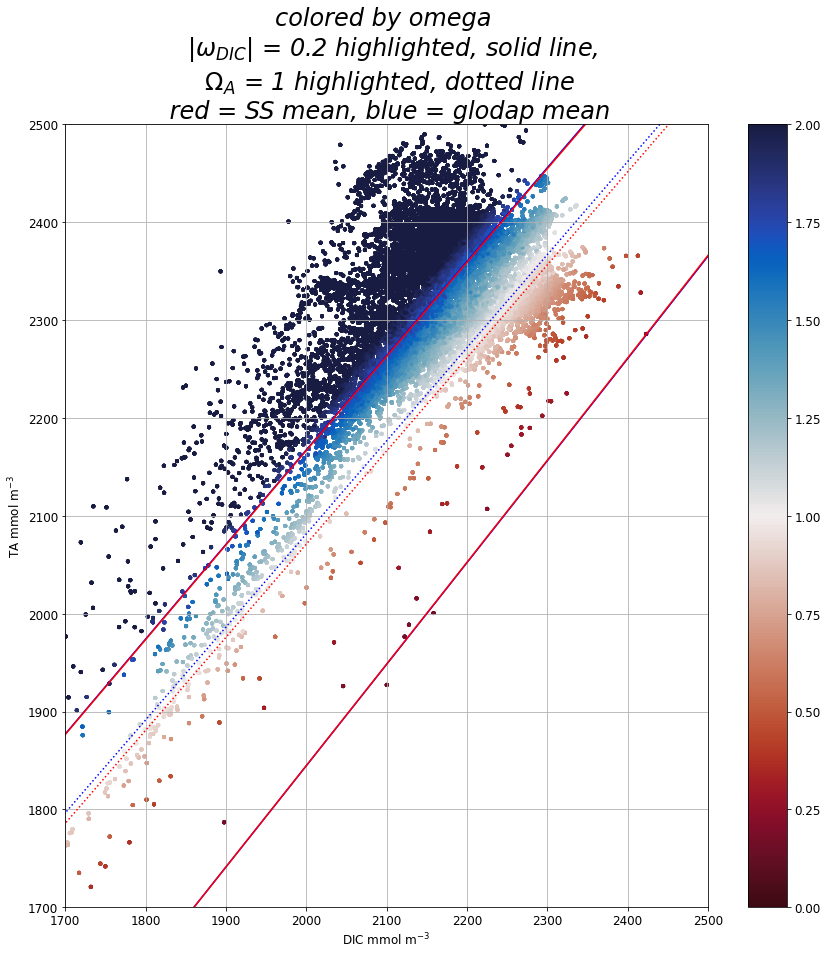

In [35]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 10}

fact = 1.2
fig = plt.figure(figsize=(12*fact,12*fact))

talph = 1
ax = plt.subplot(1,1,1)
fs = 10
tcol = 'black'
tlw = 4.5
ms = 20

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
#     ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
#                             edgecolor=tcol, fc=tcol, alpha = 0.2, lw=2)
#     ax.add_patch(ellipse)
#     ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
#             np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
#            color = tcol, marker = '.', markersize = ms, \
#             linestyle = '',\
#            label = tnam, alpha = 1)

    x = tDIC[filt_comp]
    y = tALK[filt_comp]
    
    
    w = ax.scatter(x,y,\
           c = t_OmegaA_A[filt_comp], marker = '.',\
           label = tnam, alpha = talph, vmin = 0, vmax = 2, cmap = cm.balance_r)
#####



ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC mmol m$^{-3}$')
#ax.set_title('Means and standard deviations')
ax.grid()

# ax.plot([200,202], [200,202], linestyle = '-', color = 'k', label = 'walrus')
ax.set_xlim([1700,2500])
ax.set_ylim([1700,2500])


ax.contour(X, Y, -omega_DIC_GLODAPmean, levels=[omega_lev], colors = 'b')
ax.contour(X, Y, OmegaA_A_GLODAPmean, levels=[1], linestyles = 'dotted', colors = 'b', label = 'walrusbaby' )

ax.contour(X, Y, -omega_DIC_SSmean, levels=[omega_lev], colors = 'r')
ax.contour(X, Y, OmegaA_A_SSmean, levels=[1], linestyles = 'dotted', colors = 'r', label = 'walrusbaby' )


ax.set_title(r'colored by omega - $\bf{b)}$ Coastal observations in TA vs. DIC space')
ax.set_title('colored by omega \n  |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line \n red = SS mean, blue = glodap mean',\
        style = 'italic', fontsize = 24)
# \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line
fig.colorbar(w)
    

#fig.savefig('./CG_FIGS/FIG_CG_08_plot.jpg')

